# Consumer Behaviour Analysis

In this kernel we'll be building a Ticket Recommendation System for a cruise company using historical consumer data from https://techassessment.blob.core.windows.net/aiap15-assessment-data/cruise_pre.db and https://techassessment.blob.core.windows.net/aiap15-assessment-data/cruise_post.db Dataset. 

The user is able to input the attributes they are looking for when booking for a cruise ship. This input can be in the form of a questionnaire or by selecting specific attributes from a list. Given these x features, the model can predict the type of tickets potential customers are most likely to purchase.

In [58]:
# Import required libraries
import math
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import datetime
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)  # To display all columns

ModuleNotFoundError: No module named 'sklearn'

**Importing dataset**
Next, we import the sqlite3 module and then create a connection object which will connect us to the database and will let us execute the SQL statements.
  > 1. sqlite3.connect(Database)
  > 2. read_sql_query: read SQL query into a dataframe
  > 3. Merge the two dataset using join on 'Ext_Intcode' feature

In [3]:
preDb_path, postDb_path = './data/cruise_pre.db' , './data/cruise_post.db'

# Read sqlite query results into a pandas DataFrame
preDb = pd.read_sql_query("SELECT * from cruise_pre", sqlite3.connect(preDb_path), index_col='index')
postDb = pd.read_sql_query("SELECT * from cruise_post", sqlite3.connect(postDb_path), index_col='index')

In [4]:
preDb.head(4)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode
index,,,,,,,,,,,,,,,,,,
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL


In [5]:
postDb.head(4)

,Cruise Name,Ticket Type,Cruise Distance,Ext_Intcode,WiFi,Dining,Entertainment
index,,,,,,,
0,Blastoise,None,3567 KM,LB446RWOOZI,1.0,1,1.0
1,Blastoise,Deluxe,672 KM,LB138HKBECM,NaN,0,1.0
2,IAPRAS,Deluxe,1167 KM,BL713UHBAAN,NaN,0,0.0
3,Lapras,Deluxe,280 KM,LB243DMKCFL,NaN,0,1.0




<b> Join the two dataframe using inner join</b>

In [6]:
# join the two dataframe using pd.merge()
df = pd.merge(preDb, postDb, on='Ext_Intcode')
df.head(4)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,1.0,1,1.0
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,NaN,0,1.0
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,1167 KM,NaN,0,0.0
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL,Lapras,Deluxe,280 KM,NaN,0,1.0


In [7]:
print(df.shape)

(141538, 24)


In summary, there is a total of 24 features, where 21 features are qualitative in nature and 3 quantitative features. Among the 21 qualitative features, a majority are ordinal data (13 features) from a likert scale while the rest are nominal. 
<div> <img src="im/data-attribute.png" width="600"/> </div>

## Data Preprocessing

After gaining a basic understanding of the dataset such as the features, data types, and the number of rows and columns, the next step in the preprocessing pipeline is to process the data into a cleaner format such that meaningful information can be extracted. There are three phases of data preprocessing.

**Data Cleaning**
The first step of data preprocessing is data cleaning. This refers to the process of checking for missing or noisy data. During this step, we either drop or impute data. 
  > 1. Format qualitative fields and standardize units for numerics  
  > 2. Identify columns that contain a single value / delete columns that contain a single value
  > 3. Identify rows that contain duplicate data / delete rows that contain duplicate data
  > 4. Consider columns that have very few values
  > 5. Remove columns that have a low variance
  > 6. Format qualitative fields and standardize units for numerics 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141538 entries, 0 to 141537
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Gender                                      127308 non-null  object 
 1   Date of Birth                               126056 non-null  object 
 2   Source of Traffic                           141538 non-null  object 
 3   Onboard Wifi Service                        120910 non-null  object 
 4   Embarkation/Disembarkation time convenient  125005 non-null  float64
 5   Ease of Online booking                      122047 non-null  float64
 6   Gate location                               123400 non-null  float64
 7   Logging                                     141538 non-null  object 
 8   Onboard Dining Service                      123793 non-null  object 
 9   Online Check-in                             124909 non-null  float64
 

**Format qualitative fields and standardize units for quantitative fields** for each feature in the data.
>  1. [Qualtitative] Capitalize fields for 'Gender', 'Source of Traffic', 'Onboard Wifi Service', 'Onboard Dining Service', 'Onboard Entertainment', 'Cruise Name' and 'Ticket Type'
>  2. [Qualtitative] Format date fields for 'Date of Birth', 'Logging'
>  3. [Quantitative] Standardize units for 'Cruise Distance'

In [9]:
# Format qualitative fields 
capital_fields = ['Gender', 'Source of Traffic', 'Onboard Wifi Service', 'Onboard Dining Service', 
                  'Onboard Entertainment', 'Cruise Name', 'Ticket Type']
for header in capital_fields:
    df[header] = df[header].str.capitalize()
df['Date of Birth'] = pd.to_datetime(pd.to_datetime(df['Date of Birth'], format='mixed').dt.strftime('%d/%m/%Y'), format = '%d/%m/%Y')
df['Logging'] = pd.to_datetime(pd.to_datetime(df['Logging'], format='mixed').dt.strftime('%d/%m/%Y %H:%M:%S'), format = '%d/%m/%Y %H:%M:%S')

In [10]:
## Format quantitative fields: 
### Distance conversion; convert all distance units from miles to kilometers.

units = set(k.split(' ')[-1] for k in df['Cruise Distance'].dropna())
print(units)

def convert_miles_to_km(miles):
    return float(miles) * 1.60934

def convert_distance(row):
    if row['Cruise Distance']:
        data = row['Cruise Distance'].split(' ')
        unit = data[-1]
        if unit == 'Miles':
            return convert_miles_to_km(data[0])
        elif unit == 'KM':
            return float(data[0])
    return 0
    
df['Cruise Distance'] = df.apply(convert_distance, axis=1)

{'KM', 'Miles'}


In [11]:
df = df.replace('', np.nan)
df = df.fillna(np.nan)

In [12]:
df.describe()

,Date of Birth,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Online Check-in,Cabin Comfort,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Distance,WiFi,Dining,Entertainment
count,126056,125005.000000,122047.000000,123400.000000,141538,124909.000000,116917.000000,126950.000000,116869.000000,126389.000000,122059.000000,118824.000000,141538.000000,67758.000000,141538.000000,77969.000000
mean,1978-09-16 15:15:33.527955840,3.055886,2.759642,2.978104,2023-05-25 21:05:05.765236224,3.249790,3.440193,3.385238,3.634360,3.311048,3.642845,3.285658,961.761347,0.500561,0.499187,0.504098
min,1800-01-09 00:00:00,0.000000,0.000000,0.000000,2023-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-6416.438580,0.000000,0.000000,0.000000
25%,1971-01-15 00:00:00,2.000000,2.000000,2.000000,2023-03-14 15:07:15,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,236.000000,0.000000,0.000000,0.000000
50%,1982-12-09 00:00:00,3.000000,3.000000,3.000000,2023-05-22 11:29:30,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,650.000000,1.000000,0.000000,1.000000
75%,1995-12-23 00:00:00,4.000000,4.000000,4.000000,2023-07-30 13:10:45,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1562.000000,1.000000,1.000000,1.000000
max,2016-12-28 00:00:00,5.000000,5.000000,5.000000,2023-12-08 23:58:00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7987.154420,1.000000,1.000000,1.000000
std,NaN,1.525412,1.400819,1.277604,NaN,1.351436,1.321744,1.286991,1.178282,1.266061,1.176825,1.313191,1255.191492,0.500003,0.500001,0.499986


**Handle invalid/missing/duplicated values**. 
>  1. [Missing] Drop rows that do not contain target_value 'Ticket Type'
>  2. [Duplicate] Duplicate Ext_Intcode records exists.
>  3. [Invalid] Negative values or zero values for 'Cruise Distance'.
>  4. [Missing] Drop 'Cruise Name' which are None since it is qualitative nominal data that does not provide meaningful data.
>  5. [Invalid] 'Embarkation/Disembarkation time convenient', 'Ease of Online booking', 'Gate location','Online Check-in', Cabin Comfort', 'Cabin service', 'Onboard Service', 'Cleanliness', 'WiFi', 'Dining' and 'Entertainment' has out of range data. 
>  6. [Invalid] Handle 'WiFi', 'Dining' and 'Entertainment' features since they have a large proportion of out of range data.
>  7. [Missing] Handle remaining ordinal data missing values with mean or median values 

In [13]:
# 1. [Missing] Drop rows where target is NULL
df.dropna(subset=['Ticket Type'], inplace=True)

In [14]:
# 2. [Duplicate] Duplicated PK check at 'Ext_Intcode' and 'Date of Birth' 
isDuplicated = pd.DataFrame(df[df.duplicated(subset=['Ext_Intcode','Date of Birth'])])
print("> Duplicated records exists. This is checked by using passenger's 'Ext_Intcode' and 'Date of Birth'")
print("> Handle these duplicates using aggregation where missing/NaN values are replaced by values from similar rows")
isDuplicated.head(4)

> Duplicated records exists. This is checked by using passenger's 'Ext_Intcode' and 'Date of Birth'
> Handle these duplicates using aggregation where missing/NaN values are replaced by values from similar rows


,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
5,Male,1960-07-01,Direct - company website,Somewhat important,4.0,2.0,NaN,2023-01-01 00:06:00,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS,Lapras,Standard,1842.69430,NaN,1,NaN
6,Male,1960-07-01,Direct - company website,Somewhat important,4.0,2.0,NaN,2023-01-01 00:11:00,Not at all important,2.0,1.0,Not at all important,3.0,3.0,5.0,2.0,1.0,LB218CFLOBS,Lapras,Standard,1842.69430,NaN,1,NaN
7,Male,1960-07-01,Direct - company website,Somewhat important,4.0,2.0,NaN,2023-01-01 00:11:00,Not at all important,2.0,1.0,Not at all important,3.0,3.0,5.0,2.0,1.0,LB218CFLOBS,Lapras,Standard,1842.69430,NaN,1,NaN
15,Female,2000-08-05,Direct - company website,NaN,5.0,1.0,5.0,2023-01-01 00:21:00,Extremely important,1.0,NaN,Extremely important,5.0,NaN,5.0,5.0,NaN,LB810DDUDEB,Blast,Standard,379.80424,NaN,0,NaN


In [15]:
# 2. [Duplicate] Each PK's NaN values are replaced by non nan values from similar rows 
#excludeCols = ('Source of Traffic', 'Logging', 'Dining')
excludeCols = ()
selectCols = [col for col in df.columns if col not in excludeCols]
for _ in selectCols:
    new_df = df.groupby('Ext_Intcode')[selectCols].first()
new_df.set_index('Ext_Intcode')
new_df = new_df.drop(columns=['Ext_Intcode'])
new_df[new_df.index=='LB218CFLOBS']

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
Ext_Intcode,,,,,,,,,,,,,,,,,,,,,,,
LB218CFLOBS,Male,1960-07-01,Direct - company website,Somewhat important,4.0,2.0,NaN,2023-01-01 00:06:00,Not at all important,2.0,1.0,Not at all important,3.0,3.0,5.0,2.0,1.0,Lapras,Standard,1842.6943,NaN,1,NaN


In [16]:
# 3. [Invalid] Check negative and zero values for 'Cruise Distance'
# Check that cruise distance is the same in each duplicated group since zero is a non nan value. And 2. [Duplicated] selects the first non NaN value
isValidReplacement = all([len(set(group_data['Cruise Distance'])) == 1 for _, group_data in df.groupby('Ext_Intcode')])
if isValidReplacement:
    field = 'Cruise Distance'
    isInvalid= new_df[new_df[field]<=0].shape[0]
    percInvalid = isInvalid/new_df[[field]].shape[0]*100
    print("> There are %d (%.1f%%) invalid and missing data in '%s'" % (isInvalid, percInvalid, field))
    print("> With ~%d%% of its data being missing or invalid, it is crucial to impute the invalid data by estimation. Estimate cruise distance by 'Cruise Name' and 'Ticket Type'" % (round(percInvalid/10)*10))

> There are 19438 (17.5%) invalid and missing data in 'Cruise Distance'
> With ~20% of its data being missing or invalid, it is crucial to impute the invalid data by estimation. Estimate cruise distance by 'Cruise Name' and 'Ticket Type'


In [17]:
#  3.0 [Invalid] Handle missing invalid data in 'Cruise Distance'
# >3.1 [Invalid] Apply abs() to negative values 'Cruise Distance'
#  3.2 [Invalid] Impute 0 values in 'Cruise Distance' by estimating using the mean or meadian of 
#  'Cruise Name' and 'Ticket Type' group
new_df['Cruise Distance'] = abs(new_df['Cruise Distance'])

In [18]:
#  3.0 [Invalid] Handle missing invalid data in 'Cruise Distance'
#  3.1 [Invalid] Apply abs() to negative values 'Cruise Distance'
# >3.2 [Invalid] Impute 0 values in 'Cruise Distance' by estimation using the mean or meadian of  
# 'Cruise Name' and 'Ticket Type' group
checkCruiseName = "Cruise Name"
checkTixType = "Ticket Type"
unqCruiseNames = set(new_df[checkCruiseName])
unqTixType = set(new_df[checkTixType])
print("> There are %d unique '%s': %s" % (len(unqCruiseNames), checkCruiseName, unqCruiseNames))
print("> There are %d unique '%s': %s" % (len(unqTixType), checkTixType, unqTixType))

> There are 7 unique 'Cruise Name': {'Lap', 'Lapras', None, 'Blast', 'Iapras', 'Blastoise', 'Blast0ise'}
> There are 3 unique 'Ticket Type': {'Standard', 'Luxury', 'Deluxe'}


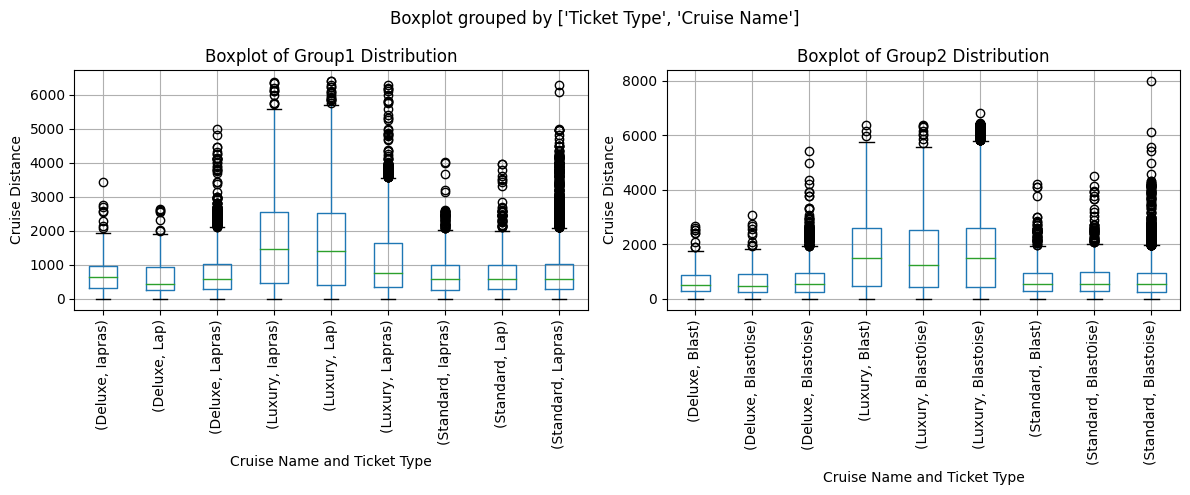

In [19]:
#  3.0 [Invalid] Handle missing invalid data in 'Cruise Distance'
#  3.1 [Invalid] Apply abs() to negative values 'Cruise Distance'
# >3.2 [Invalid] Impute 0 values in 'Cruise Distance' by estimation using the mean or meadian of  
# 'Cruise Name' and 'Ticket Type' group
isXPras = new_df[(new_df['Cruise Name']=='Lapras') | (new_df['Cruise Name']=='Iapras') | (new_df['Cruise Name']=='Lap')]
isXBlast = new_df[(new_df['Cruise Name']=='Blast0ise') | (new_df['Cruise Name']=='Blast') | (new_df['Cruise Name']=='Blastoise')]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
isXPras.boxplot(column='Cruise Distance', by=['Ticket Type', 'Cruise Name'], ax=axes[0])
isXBlast.boxplot(column='Cruise Distance', by=['Ticket Type', 'Cruise Name'], ax=axes[1])

axes[0].set_title("Boxplot of Group1 Distribution")
axes[1].set_title("Boxplot of Group2 Distribution")

for ax in axes:
    ax.set_xlabel("Cruise Name and Ticket Type")
    ax.set_ylabel("Cruise Distance")

for ax in axes:
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

From the boxplot, we can observe that Imputing zero values with the mean in groups that contain a significant number of outliers can be problematic, as it may result in imputed values that do not faithfully reflect the underlying data due to the influence of outliers. As such, the median is used to impute zero values in 'Cruise Distance'

In [20]:
#  3.0 [Invalid] Handle missing invalid data in 'Cruise Distance'
#  3.1 [Invalid] Apply abs() to negative values 'Cruise Distance'
# >3.2 [Invalid] Impute 0 values in 'Cruise Distance' by estimation using the median of 'Cruise Name' and 'Ticket Type' group
group_median = new_df.groupby(['Ticket Type', 'Cruise Name'])['Cruise Distance'].median()
new_df['Cruise Distance'] = new_df.apply(lambda row: group_median[row['Ticket Type'], row['Cruise Name']] \
                                         if row['Cruise Distance'] == 0 and row['Ticket Type'] and row['Cruise Name']  \
                                         else row['Cruise Distance'], axis=1)

In [21]:
#  3.0  [Invalid] Handle missing invalid data in 'Cruise Distance'
#  3.1 [Invalid] Apply abs() to negative values 'Cruise Distance'
#  3.2 [Invalid] Impute 0 values in 'Cruise Distance' by estimation using the median of 'Cruise Name' and 'Ticket Type' group
# >3.3 [Invalid] Drop rows where 'Cruise Distance'==0 since the rankings of each perceived importance is dependent on this feature to a large extent
print(new_df[new_df['Cruise Distance'] != 0].shape)
new_df = new_df[new_df['Cruise Distance'] != 0]

(109547, 23)


In [22]:
# 4. [Missing] Drop 'Cruise Name' which are None since it is qualitative nominal data that does not provide meaningful data.
field = 'Cruise Name'
isInvalid= new_df[new_df['Cruise Name'].isnull()].shape[0]
percInvalid = isInvalid/new_df[[field]].shape[0]*100
print("> There are %d (%.1f%%) invalid and missing data in '%s'" % (isInvalid, percInvalid, field))
new_df = new_df.drop(columns=['Cruise Name'])

> There are 11840 (10.8%) invalid and missing data in 'Cruise Name'


In [23]:
new_df.describe()

,Date of Birth,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Online Check-in,Cabin Comfort,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Distance,WiFi,Dining,Entertainment
count,97476,96737.000000,94512.000000,95462.000000,109547,96766.000000,95779.000000,98184.000000,95764.000000,97811.000000,94498.000000,97331.000000,109547.000000,52448.000000,109547.000000,60423.000000
mean,1978-09-16 09:02:11.626246496,3.057269,2.755989,2.978567,2023-05-26 01:07:35.948405760,3.249323,3.437079,3.384268,3.632565,3.305047,3.640977,3.285747,1238.444676,0.500972,0.500981,0.503020
min,1800-01-09 00:00:00,0.000000,0.000000,0.000000,2023-01-01 00:01:00,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000
25%,1971-01-15 00:00:00,2.000000,2.000000,2.000000,2023-03-14 18:36:30,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,472.000000,0.000000,0.000000,0.000000
50%,1982-11-13 00:00:00,3.000000,3.000000,3.000000,2023-05-22 16:37:00,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,862.000000,1.000000,1.000000,1.000000
75%,1996-01-02 00:00:00,4.000000,4.000000,4.000000,2023-07-30 17:28:00,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1678.000000,1.000000,1.000000,1.000000
max,2016-12-28 00:00:00,5.000000,5.000000,5.000000,2023-12-08 23:58:00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7987.154420,1.000000,1.000000,1.000000
std,NaN,1.525783,1.401235,1.278284,NaN,1.351181,1.321344,1.287220,1.178245,1.268331,1.179008,1.313410,1057.755579,0.500004,0.500001,0.499995


In [24]:
# 5. [Invalid] From the dataset description 'Embarkation/Disembarkation time convenient', 'Ease of Online booking', 
# 'Gate location','Online Check-in', Cabin Comfort', 'Cabin service', 'Onboard Service', 'Cleanliness', 'WiFi', 'Dining' 
# and 'Entertainment' has out of range where '0' is present in the data.

rangeCheck = pd.concat([new_df.iloc[:, 4:7],new_df.iloc[:, 9:11],new_df.iloc[:, 12],new_df.iloc[:, 15:17]\
                        ,new_df.iloc[:, 20:]], axis=1)
for i in rangeCheck.columns:
    zero_count = rangeCheck[rangeCheck[i]==0.0].shape[0]
    perc = zero_count/new_df[i].shape[0]*100
    print('> %s, "0" response : %d (%.1f%%)' % (i,zero_count,perc))

> Embarkation/Disembarkation time convenient, "0" response : 4936 (4.5%)
> Ease of Online booking, "0" response : 4118 (3.8%)
> Gate location, "0" response : 1 (0.0%)
> Online Check-in, "0" response : 2281 (2.1%)
> Cabin Comfort, "0" response : 1 (0.0%)
> Cabin service, "0" response : 4 (0.0%)
> Onboard Service, "0" response : 4 (0.0%)
> Cleanliness, "0" response : 13 (0.0%)
> Dining, "0" response : 54666 (49.9%)
> Entertainment, "0" response : 30029 (27.4%)


With minimal incorrect response (<5%) values for 'Embarkation/Disembarkation time convenient', 'Ease of Online booking', 'Gate location','Online Check-in', Cabin Comfort', 'Cabin service', 'Onboard Service', 'Cleanliness' **drop entries that has response value of 0**.

In [25]:
for col in rangeCheck.columns[:-3]:
    new_df = new_df[(new_df[col] != 0.0)]
    rangeCheck = rangeCheck[(rangeCheck[col] != 0.0)]

In [26]:
#  6.0 [Invalid] Handle 'WiFi', 'Dining' and 'Entertainment' features since they have a large proportion of out of range data.
#  6.1 Check percentage of missing data for each feature
for i in new_df.columns:
    num_missing = (new_df[[i]].isnull()).sum()
    perc = num_missing/new_df.shape[0]*100
    print('> %s, Missing: %d (%.1f%%)' % (i,num_missing.iloc[0],perc.iloc[0]))

> Gender, Missing: 10200 (10.0%)
> Date of Birth, Missing: 11248 (11.1%)
> Source of Traffic, Missing: 0 (0.0%)
> Onboard Wifi Service, Missing: 12375 (12.2%)
> Embarkation/Disembarkation time convenient, Missing: 12253 (12.0%)
> Ease of Online booking, Missing: 14106 (13.9%)
> Gate location, Missing: 13034 (12.8%)
> Logging, Missing: 0 (0.0%)
> Onboard Dining Service, Missing: 12708 (12.5%)
> Online Check-in, Missing: 11899 (11.7%)
> Cabin Comfort, Missing: 12751 (12.5%)
> Onboard Entertainment, Missing: 12077 (11.9%)
> Cabin service, Missing: 10521 (10.3%)
> Baggage handling, Missing: 12774 (12.6%)
> Port Check-in Service, Missing: 10877 (10.7%)
> Onboard Service, Missing: 13962 (13.7%)
> Cleanliness, Missing: 11333 (11.1%)
> Ticket Type, Missing: 0 (0.0%)
> Cruise Distance, Missing: 0 (0.0%)
> WiFi, Missing: 52225 (51.4%)
> Dining, Missing: 0 (0.0%)
> Entertainment, Missing: 44746 (44.0%)


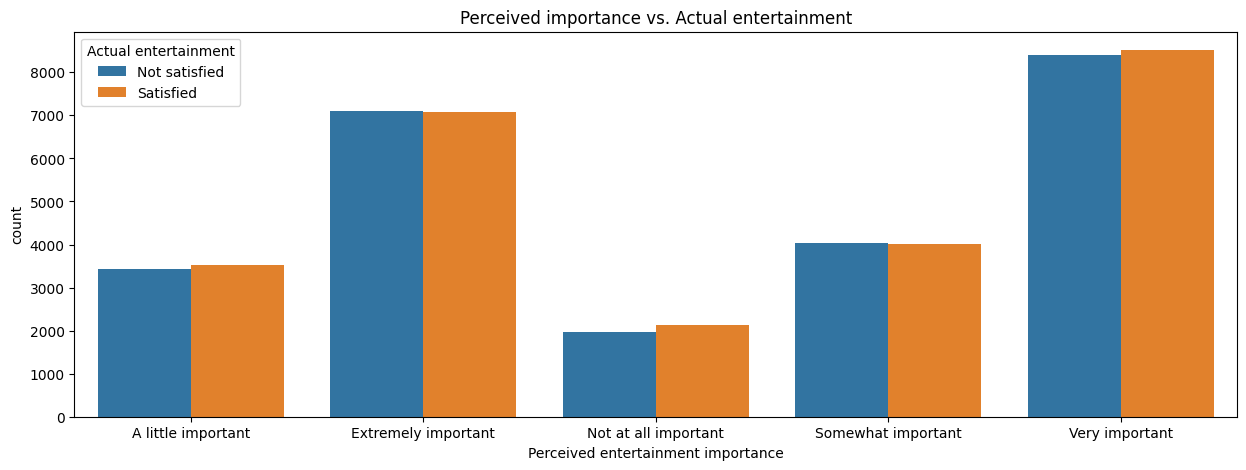

In [27]:
#  6.0 [Invalid] Handle 'WiFi', 'Dining' and 'Entertainment' features since they have a large proportion of out of range data.
#  6.1 Check percentage of missing data for each feature
#  6.2 Check perceived importance vs actual metrics. Eg: 'Entertainment' and 'Onboard Entertainment'
satisfied_scale_mapper = {0 : 'Not satisfied', 1 : 'Satisfied'}

ent_df = pd.DataFrame({'count' : new_df.groupby(['Entertainment','Onboard Entertainment']).size()}).reset_index()
ent_df['Entertainment'] = ent_df['Entertainment'].replace(satisfied_scale_mapper)
plt.subplots(figsize = (15,5))
sns.barplot(data=ent_df, x='Onboard Entertainment', y='count', hue='Entertainment')
plt.title("Perceived importance vs. Actual entertainment")
plt.legend(title='Actual entertainment', loc='upper left')
plt.xlabel('Perceived entertainment importance')
plt.show()

If both 'Onboard Entertainment' and 'Entertainment' attributes have the same variance relationship, it suggests that they do not provide any meaningful information, and we can consider dropping one of them. Redundant features can lead to multicollinearity in statistical models and might not add any value to your analysis. **Since 'Entertainment' has more missing values than 'Onboard Entertainment': Drop 'Entertainment'**

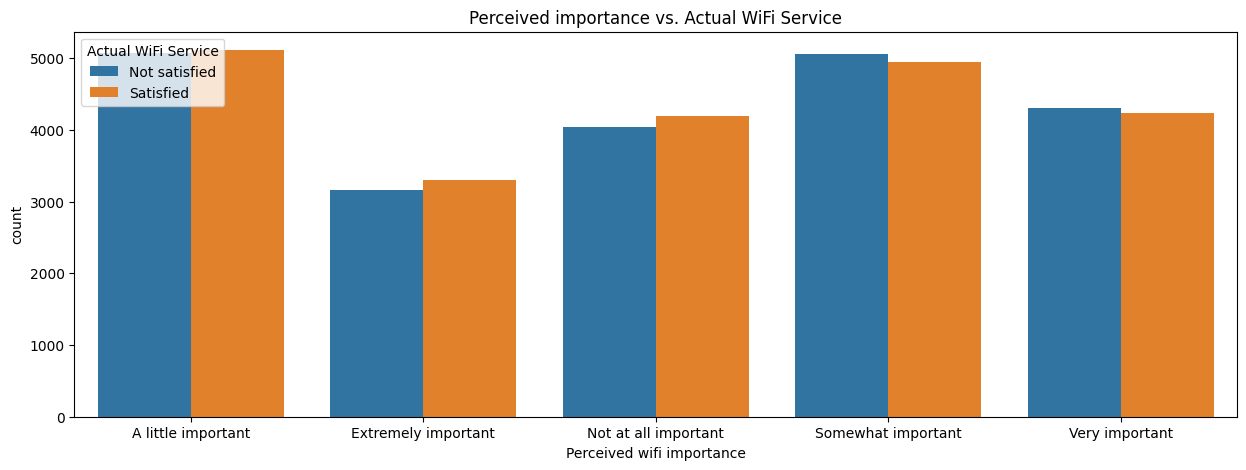

In [28]:
#  6.0 [Invalid] Handle 'WiFi', 'Dining' and 'Entertainment' features since they have a large proportion of out of range data.
#  6.1 Check percentage of missing data for each feature
#  6.2 Check perceived importance vs actual metrics. Eg: 'Entertainment' and 'Onboard Entertainment'

wifi_df = pd.DataFrame({'count' : new_df.groupby(['WiFi','Onboard Wifi Service']).size()}).reset_index()
wifi_df['WiFi'] = wifi_df['WiFi'].replace(satisfied_scale_mapper)
plt.subplots(figsize = (15,5))
sns.barplot(data=wifi_df, x='Onboard Wifi Service', y='count', hue='WiFi')
plt.title("Perceived importance vs. Actual WiFi Service")
plt.legend(title='Actual WiFi Service', loc='upper left')
plt.xlabel('Perceived wifi importance')
plt.show()

A similar relationship is observed in both 'Onboard Wifi Service' and 'WiFi' attributes. **Since 'WiFi' has more missing values than 'Onboard Wifi Service': Drop 'WiFi'**

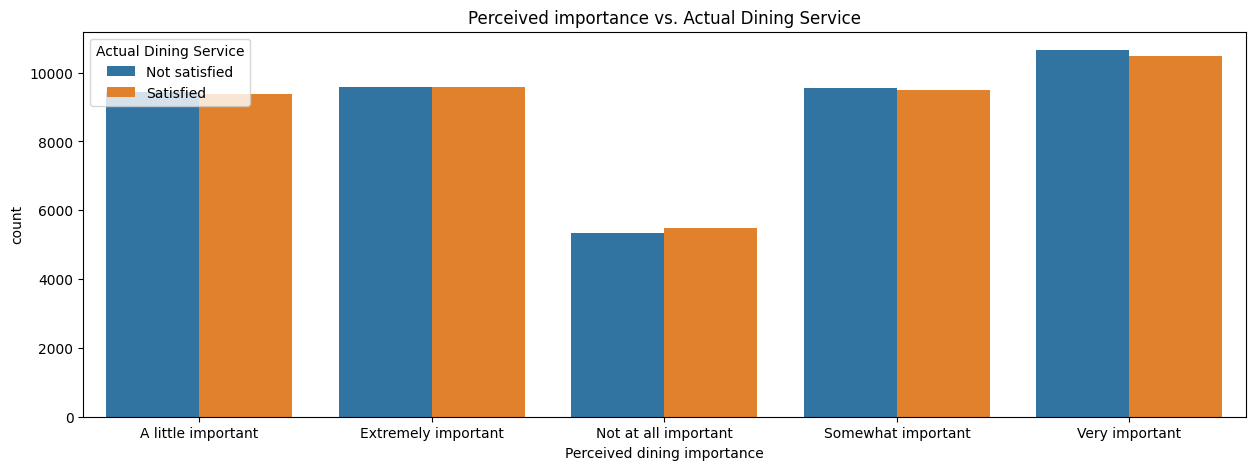

In [29]:
#  6.0 [Invalid] Handle 'WiFi', 'Dining' and 'Entertainment' features since they have a large proportion of out of range data.
#  6.1 Check percentage of missing data for each feature
#  6.2 Check perceived importance vs actual metrics. Eg: 'Entertainment' and 'Onboard Entertainment'

dine_df = pd.DataFrame({'count' : new_df.groupby(['Dining','Onboard Dining Service']).size()}).reset_index()
dine_df['Dining'] = dine_df['Dining'].replace(satisfied_scale_mapper)
plt.subplots(figsize = (15,5))
sns.barplot(data=dine_df, x='Onboard Dining Service', y='count', hue='Dining')
plt.title("Perceived importance vs. Actual Dining Service")
plt.legend(title='Actual Dining Service', loc='upper left')
plt.xlabel('Perceived dining importance')
plt.show()

A similar relationship is observed in both 'Onboard Dining Service' and 'Dining' attributes. However, it is important to consider the number of out of range data in 'Dining'. Since 50% of 'Dining' feature is 0 **'Onboard Dining Service' is a more representative feature**

In [30]:
new_df = new_df.drop(columns=['Entertainment'])
new_df = new_df.drop(columns=['WiFi'])
new_df = new_df.drop(columns=['Dining'])

In [31]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101698 entries, BL100AELMIT to LB999ZTNYSO
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Gender                                      91498 non-null   object        
 1   Date of Birth                               90450 non-null   datetime64[ns]
 2   Source of Traffic                           101698 non-null  object        
 3   Onboard Wifi Service                        89323 non-null   object        
 4   Embarkation/Disembarkation time convenient  89445 non-null   float64       
 5   Ease of Online booking                      87592 non-null   float64       
 6   Gate location                               88664 non-null   float64       
 7   Logging                                     101698 non-null  datetime64[ns]
 8   Onboard Dining Service                      88990 non-null   obj

Next, we visualize the each attribute to determine how to handle the missing values

In [32]:
new_df.head(5)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ticket Type,Cruise Distance
Ext_Intcode,,,,,,,,,,,,,,,,,,,
BL100AELMIT,Male,1967-02-17,Direct - email marketing,Not at all important,1.0,NaN,1.0,2023-12-06 11:11:00,Extremely important,5.0,5.0,Very important,4.0,4.0,NaN,4.0,3.0,Luxury,150.0
BL100AQXMUS,None,2001-06-26,Direct - company website,Somewhat important,5.0,5.0,5.0,2023-03-23 14:52:00,None,NaN,3.0,Somewhat important,4.0,3.0,2.0,3.0,3.0,Luxury,1464.0
BL100BAEEDV,Male,NaT,Direct - email marketing,None,4.0,NaN,1.0,2023-01-29 06:36:00,None,NaN,5.0,Extremely important,5.0,4.0,3.0,NaN,5.0,Standard,1733.0
BL100DHMSHK,Female,2002-09-05,Indirect - social media,Not at all important,1.0,1.0,4.0,2023-03-23 01:23:00,None,1.0,3.0,Somewhat important,3.0,4.0,3.0,NaN,3.0,Standard,862.0
BL100EKPEJI,Male,1982-05-14,Direct - email marketing,A little important,4.0,2.0,1.0,2023-06-05 06:16:00,Somewhat important,2.0,NaN,Somewhat important,5.0,4.0,3.0,5.0,3.0,Standard,678.0


In [33]:
# Imputation with a separate category
new_df['Onboard Wifi Service'].fillna('Not Specified', inplace=True)
new_df['Onboard Dining Service'].fillna('Not Specified', inplace=True)
new_df['Onboard Entertainment'].fillna('Not Specified', inplace=True)

In [34]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101698 entries, BL100AELMIT to LB999ZTNYSO
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Gender                                      91498 non-null   object        
 1   Date of Birth                               90450 non-null   datetime64[ns]
 2   Source of Traffic                           101698 non-null  object        
 3   Onboard Wifi Service                        101698 non-null  object        
 4   Embarkation/Disembarkation time convenient  89445 non-null   float64       
 5   Ease of Online booking                      87592 non-null   float64       
 6   Gate location                               88664 non-null   float64       
 7   Logging                                     101698 non-null  datetime64[ns]
 8   Onboard Dining Service                      101698 non-null  obj

In [35]:
new_df.head(4)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ticket Type,Cruise Distance
Ext_Intcode,,,,,,,,,,,,,,,,,,,
BL100AELMIT,Male,1967-02-17,Direct - email marketing,Not at all important,1.0,NaN,1.0,2023-12-06 11:11:00,Extremely important,5.0,5.0,Very important,4.0,4.0,NaN,4.0,3.0,Luxury,150.0
BL100AQXMUS,None,2001-06-26,Direct - company website,Somewhat important,5.0,5.0,5.0,2023-03-23 14:52:00,Not Specified,NaN,3.0,Somewhat important,4.0,3.0,2.0,3.0,3.0,Luxury,1464.0
BL100BAEEDV,Male,NaT,Direct - email marketing,Not Specified,4.0,NaN,1.0,2023-01-29 06:36:00,Not Specified,NaN,5.0,Extremely important,5.0,4.0,3.0,NaN,5.0,Standard,1733.0
BL100DHMSHK,Female,2002-09-05,Indirect - social media,Not at all important,1.0,1.0,4.0,2023-03-23 01:23:00,Not Specified,1.0,3.0,Somewhat important,3.0,4.0,3.0,NaN,3.0,Standard,862.0


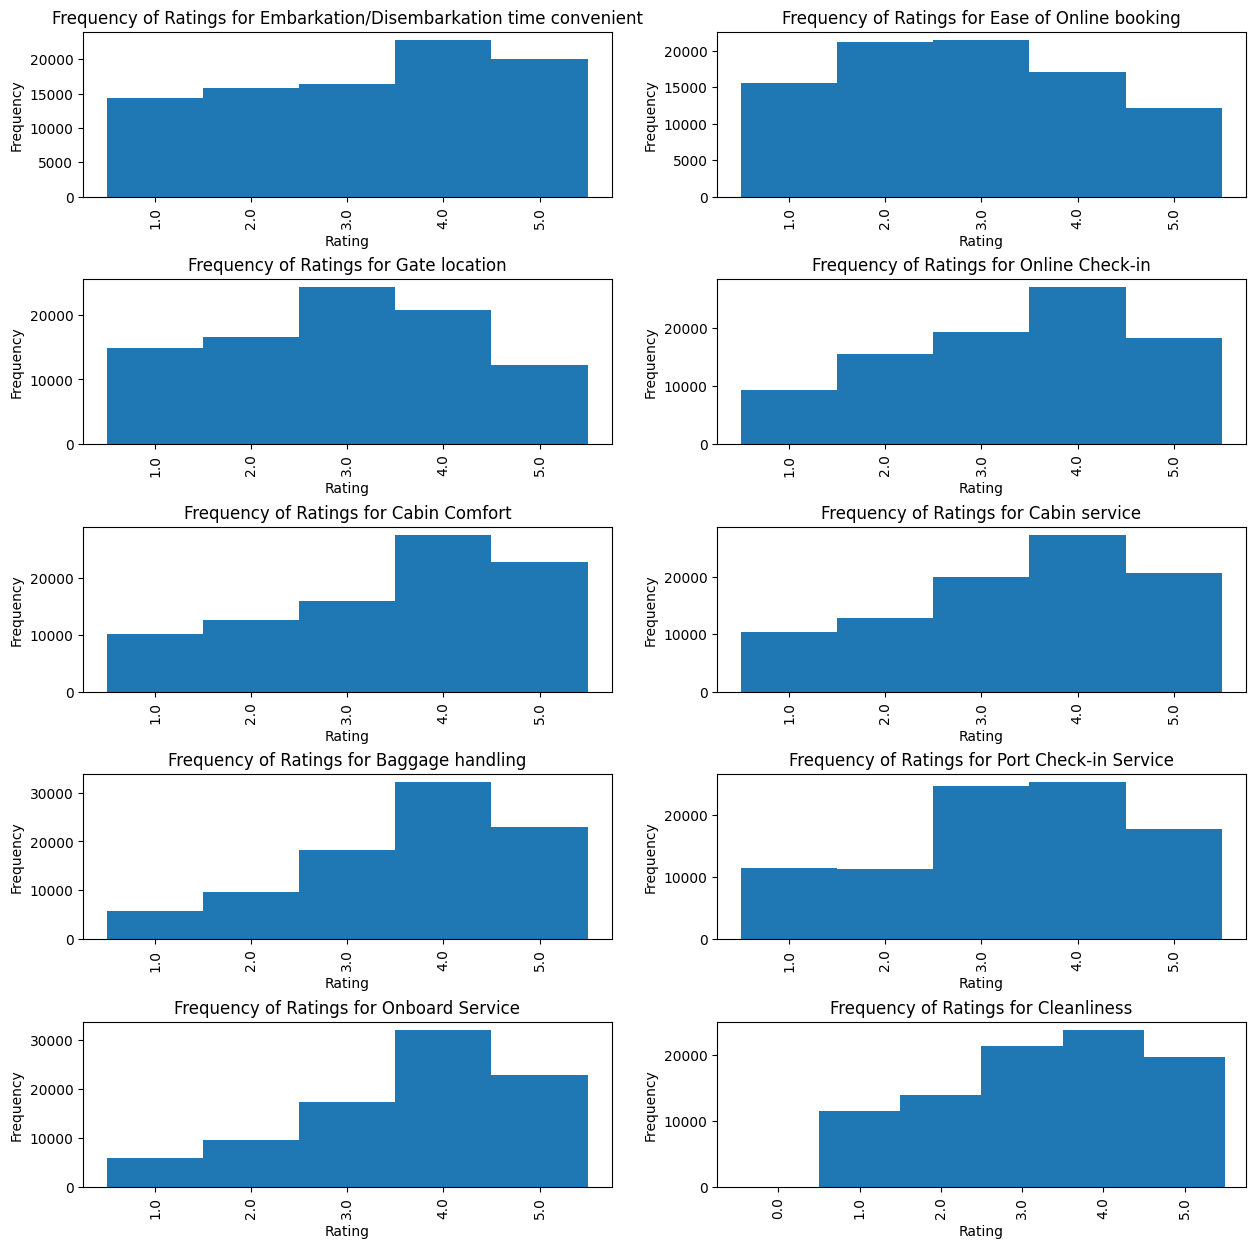

> Mean is equals to median of Embarkation/Disembarkation time convenient is: True
> Mean is equals to median of Ease of Online booking is: True
> Mean is equals to median of Gate location is: True
> Mean is equals to median of Online Check-in is: False
> Mean is equals to median of Cabin Comfort is: False
> Mean is equals to median of Cabin service is: False
> Mean is equals to median of Baggage handling is: True
> Mean is equals to median of Port Check-in Service is: True
> Mean is equals to median of Onboard Service is: True
> Mean is equals to median of Cleanliness is: True


In [52]:
ord_data = ('Embarkation/Disembarkation time convenient', 'Ease of Online booking', 'Gate location', \
            'Online Check-in','Cabin Comfort','Cabin service','Baggage handling', 'Port Check-in Service',\
            'Onboard Service','Cleanliness')

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5) 

for idx, feature in enumerate(ord_data):
    row_index, col_index = idx // 2, idx % 2
    ax = axes[row_index, col_index]
    
    feature_data = new_df[feature].value_counts().sort_index()
    feature_data.plot(kind='bar', width=1.0, ax=ax)
    ax.set(xlabel="Rating", ylabel="Frequency")
    ax.set_title(f"Frequency of Ratings for {feature}")

plt.show()

for feature in ord_data:
    print(f"> Mean is equals to median of {feature} is:", new_df[feature].median()==round(new_df[feature].mean(), 0))

In [53]:
# For features that have no difference between the mean and median: replace with either

new_df["Embarkation/Disembarkation time convenient"].fillna(new_df["Embarkation/Disembarkation time convenient"].mean(), inplace = True)
new_df["Ease of Online booking"].fillna(new_df["Ease of Online booking"].mean(), inplace = True)
new_df["Gate location"].fillna(new_df["Gate location"].mean(), inplace = True)
new_df["Baggage handling"].fillna(new_df["Baggage handling"].mean(), inplace = True)
new_df["Port Check-in Service"].fillna(new_df["Port Check-in Service"].mean(), inplace = True)
new_df["Onboard Service"].fillna(new_df["Onboard Service"].mean(), inplace = True)
new_df["Cleanliness"].fillna(new_df["Cleanliness"].mean(), inplace = True)

# Otherwise, replace with the median
new_df["Online Check-in"].fillna(new_df["Online Check-in"].median(), inplace = True)
new_df["Cabin Comfort"].fillna(new_df["Cabin Comfort"].median(), inplace = True)
new_df["Cabin service"].fillna(new_df["Cabin service"].median(), inplace = True)

In [54]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101698 entries, BL100AELMIT to LB999ZTNYSO
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Gender                                      91498 non-null   object        
 1   Date of Birth                               90450 non-null   datetime64[ns]
 2   Source of Traffic                           101698 non-null  object        
 3   Onboard Wifi Service                        101698 non-null  object        
 4   Embarkation/Disembarkation time convenient  101698 non-null  float64       
 5   Ease of Online booking                      101698 non-null  float64       
 6   Gate location                               101698 non-null  float64       
 7   Logging                                     101698 non-null  datetime64[ns]
 8   Onboard Dining Service                      101698 non-null  obj

In [56]:
# Drop 'Gender' and 'Date of Birth' since there are missing values and they do not provide meaningful data 
new_df = new_df.drop(columns=['Gender'])
new_df = new_df.drop(columns=['Date of Birth'])

**Data Transformation**
After handling missing/duplicated/invalid data, the second step of data preprocessing is data transformation. This includes:

 > 1. Data normalization: min-max normalization/z-score normalization.
 > 2. Data aggregation
 > 3. Data smoothing
 > 4. Data discretization
 > 5. Data encoding
 > 6. Attribute construction 

**Perform data encoding** on 'Onboard Wifi Service', 'Onboard Dining Service' and 'Onboard Entertainment'

In [29]:
age_df = df[['Date of Birth']]


In [57]:
new_df.head(4)

,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ticket Type,Cruise Distance
Ext_Intcode,,,,,,,,,,,,,,,,,
BL100AELMIT,Direct - email marketing,Not at all important,1.0,2.875308,1.0,2023-12-06 11:11:00,Extremely important,5.0,5.0,Very important,4.0,4.0,3.295152,4.000000,3.0,Luxury,150.0
BL100AQXMUS,Direct - company website,Somewhat important,5.0,5.000000,5.0,2023-03-23 14:52:00,Not Specified,4.0,3.0,Somewhat important,4.0,3.0,2.000000,3.000000,3.0,Luxury,1464.0
BL100BAEEDV,Direct - email marketing,Not Specified,4.0,2.875308,1.0,2023-01-29 06:36:00,Not Specified,4.0,5.0,Extremely important,5.0,4.0,3.000000,3.645129,5.0,Standard,1733.0
BL100DHMSHK,Indirect - social media,Not at all important,1.0,1.000000,4.0,2023-03-23 01:23:00,Not Specified,1.0,3.0,Somewhat important,3.0,4.0,3.000000,3.645129,3.0,Standard,862.0
